# Examining Factors Influencing Survival on the Titanic 

In this project, a dataset containing details about a subset of the passengers who were onboard the Titanic is analyzed with the objective of checking if factors such as age, sex, and socio-economic status influenced the survival rates of passengers. Details about the dataset fields are found on the [Titanic Kaggle page](https://www.kaggle.com/c/titanic/data).

## Question Phase

Based on information about the dataset, I chose to explore the following questions in this project.

1\. Did the "women and children first" code of conduct hold good during the Titanic evacuation?

2\. How did the survival percentage differ across the socio-economic status of passengers?

3\. Were passengers travelling as part of a family more likely or less likely to survive from those who travelled alone?

## Wrangling Phase

### Data Acquisition

Data acquisition was straightforward for this project and simply consisted of downloading the csv file from the Udacity page and loading it into a Pandas dataframe.  

In [21]:
# Import statements
%matplotlib inline
import pandas as pd
import numpy as np
import scipy.stats
import seaborn as sns

In [22]:
# Reading csv file into pandas dataframe
titanic_data_df = pd.read_csv('titanic-data.csv')

### Data Cleaning

Data cleaning involved inspecting the dataset with a view toward:
* eliminating unnecessary information, 
* removing/replacing NaNs,
* aggregating columns to simplify analysis, and
* replacing numeric categorical values with string equivalents for better readability.

In [23]:
# Preliminary exploration of dataset to decide on data cleaning required
titanic_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [24]:
# Removing columns that are not related to the study
titanic_data_df.drop(['PassengerId', 'Name', 'Ticket', 'Fare', 'Cabin', 'Embarked'],inplace=True,axis=1)

In [25]:
# Merging columns with number of siblings/spouses and parents/children to simplify family analysis
titanic_data_df.insert(5,'WithFamily', (titanic_data_df.SibSp + titanic_data_df.Parch) > 0)
titanic_data_df.drop(['SibSp', 'Parch'],inplace=True,axis=1)

In [26]:
# Replacing numeric categorical values with string equivalents to improve readability
titanic_data_df['Survived'].replace([0,1],['No','Yes'],inplace=True)
titanic_data_df['Pclass'].replace([1,2,3],['Upper','Middle','Lower'],inplace=True)

In [27]:
# Checking for missing values in the remaining dataset
titanic_data_df.isnull().sum()

Survived        0
Pclass          0
Sex             0
Age           177
WithFamily      0
dtype: int64

**Note:** As 177 entries constitute a substantial portion (19.87%) of the entire dataset, I created another dataset to analyze the age values by eliminating NaNs and retained the original dataset for exploring other fields. I chose to completely remove the missing data values instead of replacing by other values such as zero or the mean. This is because my analysis classifies passengers based on their age into children/adults and substituting values could potentially skew the analysis.

In [28]:
# Creating a new dataframe for age analysis without null values 
age_analysis_df = titanic_data_df.copy()
age_analysis_df.dropna(axis=0, inplace=True)

In [29]:
# Creating a column that indicates whether or not passenger is a child (age less than 18 years)
age_analysis_df.insert(2,'Child', (age_analysis_df.Age) < 18)

In [30]:
# Dropping the Age column from the original dataframe
titanic_data_df.drop('Age',inplace=True,axis=1)

## Exploration and Analysis Phase

Next, the cleaned datasets are investigated to check for patterns/insights. The analysis is organized according to the aspects mentioned in the questions. A function *compute_survival_rate* is used to compute the percentage that the passenger count accounts for within a category. 

In [31]:
# Function that computes the percentage value
def compute_percentage(value):
    return (100 * value / value.sum())

In [32]:
def compute_survival_rate(parameter):
    '''
    This function groups data on a particular index and computes count percentage within the category
    Parameter refers to a list of attributes according to which the dataset is grouped
    '''
    # Determing the dataset to the analyzed
    if 'Child' in parameter:
        df = age_analysis_df
    else:
        df = titanic_data_df
    
    # Grouping the dataset with respect to the parameters and computing the percentage
    parameter_list = ['Survived'] + parameter
    sub_group = df.groupby(parameter_list).agg({'Survived':'count'})
    sub_group['Percentage'] = sub_group.groupby(level=0).apply(compute_percentage)
    
    # Visualization by printing out values and plotting it as a barplot
    print sub_group
    if len(parameter_list) == 3:
        sns.factorplot(x=parameter_list[1], hue=parameter_list[2], col='Survived', data=df, kind='count')
    else:
        title_text = 'Categorization of passengers based on ' + str(parameter)
        ax = sub_group.unstack().plot(y='Percentage', kind='bar', stacked=True, title=title_text)
        ax.set_ylabel('Percentage')

**Effect of the sex and age range of passengers on their chances of survival**

Categorization of passengers based on sex
                 Survived  Percentage
Survived Sex                         
No       female        81   14.754098
         male         468   85.245902
Yes      female       233   68.128655
         male         109   31.871345


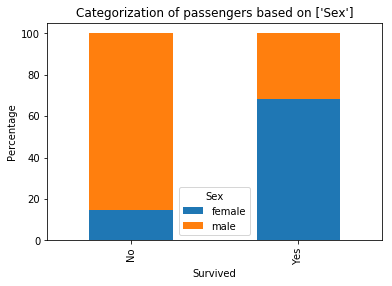

In [33]:
print 'Categorization of passengers based on sex'
compute_survival_rate(['Sex'])

**Observation:** Females make up more than two-thirds of those who survived, while 85% of those who perished were males.

Categorization of passengers based on age range
                Survived  Percentage
Survived Child                      
No       False       372   87.735849
         True         52   12.264151
Yes      False       229   78.965517
         True         61   21.034483


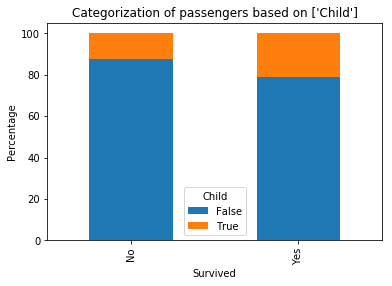

In [34]:
print 'Categorization of passengers based on age range'
compute_survival_rate(['Child'])

**Observation:** The number of survivors was greater than the number of those who perished in the case of children. In contrast, those who perished were more in the case of adults.

Categorization of passengers based on both sex and age range
                       Survived  Percentage
Survived Sex    Child                      
No       female False        47   11.084906
                True         17    4.009434
         male   False       325   76.650943
                True         35    8.254717
Yes      female False       159   54.827586
                True         38   13.103448
         male   False        70   24.137931
                True         23    7.931034


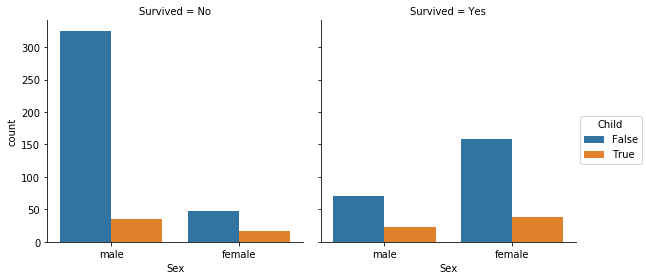

In [35]:
print 'Categorization of passengers based on both sex and age range'
df = compute_survival_rate(['Sex','Child'])

**Observation:** From the plot, it is obvious that females had a better chance of surviving than males. However, the number of male children who survived was less than the number of male children who perished, even though children seemed to have a better chance of overall survival. Therefore, using categorization of adult/child to determine survivability is not advisable. Next, a deeper analysis is conducted to check if there exists any difference in mean ages of those who survived and perished. 

In [36]:
age_analysis_df.groupby('Survived')['Age'].describe()

,count,mean,std,min,25%,50%,75%,max
Survived,,,,,,,,
No,424.0,30.626179,14.172110,1.00,21.0,28.0,39.0,74.0
Yes,290.0,28.343690,14.950952,0.42,19.0,28.0,36.0,80.0


** Statistical test **

The obtained statistics were input to GraphPad's t-test calculator to check if there is a significant difference in the means of the two categories. The result snapshot is shown below.

![Output](Result.png "T-test")

**Observation:** As indicated in the results snapshot, the obtained p value is statistically significant, which implies that age factor might be used to glean insights about the survivability of passengers. 

**Effect of the socio-economic status of passengers on their chances of survival** 

Categorization of passengers based on socio-economic class
                 Survived  Percentage
Survived Pclass                      
No       Lower        372   67.759563
         Middle        97   17.668488
         Upper         80   14.571949
Yes      Lower        119   34.795322
         Middle        87   25.438596
         Upper        136   39.766082


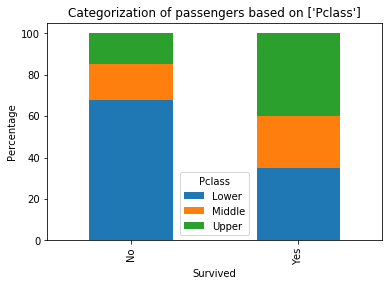

In [37]:
print 'Categorization of passengers based on socio-economic class'
compute_survival_rate(['Pclass'])

**Observation:** The stacked chart clearly shows that a majority of the upper class survived, while a majority of those from the lower class perished. However, in the middle class, the numbers of those who survived and those who perished are comparable and nothing can be concluded clearly. 

**Effect of the presence/absence of family members on passengers' chances of survival** 

Categorization of passengers based on accompanying family members
                     Survived  Percentage
Survived WithFamily                      
No       False            374   68.123862
         True             175   31.876138
Yes      False            163   47.660819
         True             179   52.339181


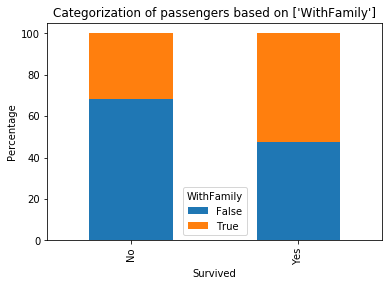

In [38]:
print 'Categorization of passengers based on accompanying family members'
compute_survival_rate(['WithFamily'])

**Observation:** The counts show that being accompanied by a family member does not appear to affect the number of passengers who survived significantly. However, a majority of those who did not survive appear to be travelling alone.

**Comprehensive analysis based on sex, class, and age range**

Categorization of passengers based on sex, socio-economic class, and age range
                              Survived  Percentage
Survived Sex    Pclass Child                      
No       female Lower  False        39    9.198113
                       True         16    3.773585
                Middle False         6    1.415094
                Upper  False         2    0.471698
                       True          1    0.235849
         male   Lower  False       182   42.924528
                       True         33    7.783019
                Middle False        82   19.339623
                       True          2    0.471698
                Upper  False        61   14.386792
Yes      female Lower  False        28    9.655172
                       True         19    6.551724
                Middle False        56   19.310345
                       True         12    4.137931
                Upper  False        75   25.862069
                       True          7    2.413793
   

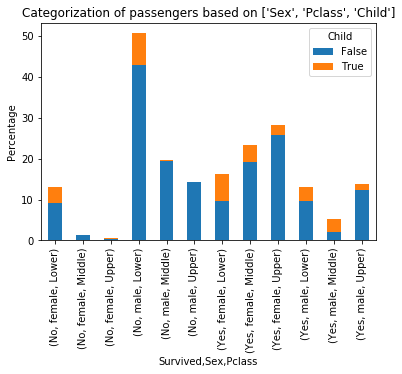

In [39]:
print 'Categorization of passengers based on sex, socio-economic class, and age range'
compute_survival_rate(['Sex', 'Pclass', 'Child'])

**Observation:** From the given dataset, it appears that upper class adult women were the most likely to survive while lower class adult males were least likely to survive.

## Conclusions Phase

** Did the "women and children first" code of conduct hold good in this case? **

Analysis reveals that out of the 290 passengers who survived, 220 were either female or children or both. In terms of percentage, this is more than 75%. Thus, it seems likely that the female passengers and children were evacuated first. This is also supported by the fact that male adults comprised more than 75% of those who did not survive.

** How did the survival percentage differ across the socio-economic status of passengers? **

The obtained statistics shows that the number of middle-class passengers who survived (87) was comparable with the number who perished (97). However, these numbers varied widely in the case of the lower and upper classes. In the case of the upper class passengers, 136 survived while 80 perished. In the lower class, 119 survived while 372 perished. From this data, it appears that the possibility of survival was lowest for passengers who belonged to lower socio-economic status, while it was high for those who belonged to the upper class.  

** Were passengers travelling as part of a family more likely or less likely to survive from those who travelled alone? ** 

Analysis of the number of family members of passengers who survived the disaster did not reveal any patterns; the survival numbers are comparable. In contrast, 374 out of 549 passengers who were travelling without family did not survive. However, as the findings were not consistent across both categories, I would not consider this as a reliable feature for determining the possibility of survival.

## Summary

From the investigated parameters of sex, class, age category, and accompanying family members, it was found that sex and class described the survivors and victims; these factors could possibly be used for predicting the survivability of a passenger given his/her demographics. There was no clear consensus on survivability with respect to age category and presence of family. 

## Limitations of this study

1\. The provided dataset comprised passenger information from 891 of the 2224 passengers. Among these, 177 entries were missing age information. Therefore, the investigated passengers constituted less that half of those who were travelling and findings in this analysis might not be applicable to the entire passenger set.  

2\. Deriving conclusions from metrics like count, percentage, and measures of central tendency or variability is not as rigorous as conducting statistical tests.

3\. In order to simplify analysis, I replaced specific information on number of siblings/spouses and parents/children by aggregate measures. This abstraction could result in overlooking patterns that might exist with respect to these features. 

4\. The analysis was restricted to demographical features of passengers. Lurking variables such as the official procedures, initiative of passengers, decisions by officials etc. could also have had an impact on the survivability of passengers. These were beyond the scope of this study.

## References

1\. [Pandas visualization](https://pandas.pydata.org/pandas-docs/stable/visualization.html)

2\. [Stackoverflow](https://stackoverflow.com/)

3\. [Seaborn visualization](http://seaborn.pydata.org/tutorial/categorical.html)

4\. [Titanic Kaggle page](https://www.kaggle.com/c/titanic/data)

5\. [GraphPad software](http://www.graphpad.com/)